# Classifying Nobel Prize Physicists by Physics Field

In this project, we will classify each Nobel Prize physicist by the physics subfield they practice.

To do this, we will gather and compare the words used in each physicist's Wikipedia entry to each physics subfield's Wikipedia entry to determine which subfield they are most associated with.

## Import the necessary packages

- Pandas: To create dataframes (DF)
- Numpy: Perform array/matrix/DF operations
- Soup packages: Collect, parse, and clean HTML (from Wikipedia in this case)
- matplotlib: Displays graphics

In [1]:
import pandas as pd
import numpy as np

from httplib2 import Http

from bs4 import BeautifulSoup, SoupStrainer

import matplotlib

%matplotlib inline

## Get Wikipedia data
The following code to create our initial nobel_df was written by Damien Benveniste (with slight modifications by me). It parses a table from the Wikipedia page for Nobel Prize Winners (as of 5 Jul 2017) and places the data in a DF named nobel_df.

For each Year (1901-2017), table contains
- Laureate
- Country (of Laureate)
- Rationale (why the Laureate deserved the prize)

In [2]:
class Parser:
    
    def __init__(self, url):  
        http = Http()
        status, response = http.request(url)
        tables = BeautifulSoup(response, "lxml", 
                              parse_only=SoupStrainer("table", {"class":"wikitable plainrowheaders sortable"}))
        self.table = tables.contents[1]
    
    def parse_table(self):      
        rows = self.table.find_all("tr")
        header = self.parse_header(rows[0])
        table_array = [self.parse_row(row) for row in rows[1:]]
        table_df = pd.DataFrame(table_array, columns=header).apply(self.clean_table, 1)
        return table_df.replace({"Year":{'':np.nan}})
        
    def parse_row(self, row):     
        columns = row.find_all(["td","th"])
        return [BeautifulSoup.get_text(col).strip() for col in columns if BeautifulSoup.get_text(col) != '']
    
    def parse_header(self, row):     
        columns = row.find_all("th")
        to_return = [BeautifulSoup.get_text(col).strip() for col in columns if BeautifulSoup.get_text(col) != ""]
        if 'Image' in to_return:
            to_return.remove('Image')
        return to_return

    def clean_table(self, row):
        if not row.iloc[0].isdigit() and row.iloc[0] != '':
            return row.shift(1)
        else:
            return row
        
url = "https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Physics"        
parser = Parser(url)   
nobel_df = parser.parse_table()
nobel_df.drop(labels = 'Ref', axis =1, inplace=True)

In [3]:
nobel_df

,Year,Laureate[A],Country[B],Rationale[C]
0,1901,Wilhelm Conrad Röntgen,Germany,"""in recognition of the extraordinary services ..."
1,1902,Hendrik Lorentz,Netherlands,"""in recognition of the extraordinary service t..."
2,NaN,Pieter Zeeman,Netherlands,None
3,1903,Antoine Henri Becquerel,France,"""for his discovery of spontaneous radioactivity"""
4,NaN,Pierre Curie,France,"""for their joint researches on the radiation p..."
5,NaN,Maria Skłodowska-Curie,Poland\n France,None
6,1904,Lord Rayleigh,United Kingdom,"""for his investigations of the densities of th..."
7,1905,Philipp Eduard Anton von Lenard,Austria-Hungary\n Germany,"""for his work on cathode rays"""
8,1906,Joseph John Thomson,United Kingdom,"""for his theoretical and experimental investig..."
9,1907,Albert Abraham Michelson,United States\n Poland,"""for his optical precision instruments and the..."


From the above output, we see ways we can clean up Nobel_df
- Column names should be cleaned up: Laureate[A] should be Laureate, etc.
- We want to drop years where no prize was awarded.
- Because in some years the prize was awarded to multiple scientists, some of our "Year" values are NaN. We wish to "forward fill" these values (If a "Year" value is missing, use the value from the previous row).

The following code accomplishes what we want.
## Clean up Nobel_df

In [4]:
#Clean the columns names
nobel_df.columns = ['Year', 'Laureate', 'Country','Rationale']

#Drop all the rows where the nobel price was not awarded
nobel_df = nobel_df.dropna(axis = 0, subset =['Country'])

#Fill the missing values in the year column
nobel_df = nobel_df.fillna(method ='ffill')


nobel_df

,Year,Laureate,Country,Rationale
0,1901,Wilhelm Conrad Röntgen,Germany,"""in recognition of the extraordinary services ..."
1,1902,Hendrik Lorentz,Netherlands,"""in recognition of the extraordinary service t..."
2,1902,Pieter Zeeman,Netherlands,"""in recognition of the extraordinary service t..."
3,1903,Antoine Henri Becquerel,France,"""for his discovery of spontaneous radioactivity"""
4,1903,Pierre Curie,France,"""for their joint researches on the radiation p..."
5,1903,Maria Skłodowska-Curie,Poland\n France,"""for their joint researches on the radiation p..."
6,1904,Lord Rayleigh,United Kingdom,"""for his investigations of the densities of th..."
7,1905,Philipp Eduard Anton von Lenard,Austria-Hungary\n Germany,"""for his work on cathode rays"""
8,1906,Joseph John Thomson,United Kingdom,"""for his theoretical and experimental investig..."
9,1907,Albert Abraham Michelson,United States\n Poland,"""for his optical precision instruments and the..."


- ### Check for null values

In [5]:
nobel_df.isnull().any()

Year         False
Laureate     False
Country      False
Rationale    False
dtype: bool

Out of curiosity, we want to see how many physicists and how many countries are contained in Nobel_df.

- ### How many physicists/countries represented?

In [6]:
#How many physicists got a nobel prize?
physicist_number =  nobel_df['Laureate'].nunique()

#How many countries are in this data set?
country_number =  nobel_df['Country'].nunique()

print(physicist_number)
print(country_number)

206
44


One issue we see with the "Country" values in Nobel_df is that when physicists from multiple countries win the Nobel Prize in a single year, the "Country" value is something like United Kingdom\n United States. We want our code to count this as two separate values (United Kingdom AND United States).
We accomplish this by creating a new column in nobel_df that splits on '\n', and then converting this to a Pandas Series.

Finally, we will count the number of times each country shows up, and display this info in a bar graph.

## Create list of all countries

In [7]:
# Split the column "Country" into a column "Country_list" of lists of countries
nobel_df["Country_list"] =  nobel_df['Country'].str.split(pat ='\n')

# We create a pandas series from this new column to ease the analysis on the countries. The sum on list is used to 
# flatten the list of lists into one list of countries.
countries = pd.Series(sum(nobel_df["Country_list"].tolist(), [])).str.strip()
countries

0              Germany
1          Netherlands
2          Netherlands
3               France
4               France
5               Poland
6               France
7       United Kingdom
8      Austria-Hungary
9              Germany
10      United Kingdom
11       United States
12              Poland
13              France
14               Italy
15             Germany
16         Netherlands
17             Germany
18              Sweden
19         Netherlands
20             Germany
21      United Kingdom
22           Australia
23      United Kingdom
24      United Kingdom
25             Germany
26             Germany
27         Switzerland
28             Germany
29         Switzerland
            ...       
208             Canada
209      United States
210      United States
211             Russia
212     United Kingdom
213        Netherlands
214             Russia
215     United Kingdom
216      United States
217          Australia
218      United States
219      United States
220        

- ### Print number of appearances per country (asc to desc order)

In [8]:
# Print the countries and the number of times they are contained in the countries pandas Series. It should
# be printed ordered by the number of times they are contained in the countries pandas Series

countries.value_counts()

United States        94
United Kingdom       27
Germany              19
France               13
Japan                11
Netherlands          10
West Germany          9
Soviet Union          7
Russia                5
Italy                 5
Switzerland           5
Poland                4
Sweden                4
Canada                4
Austria               3
Republic of China     3
Denmark               3
Hungary               2
Australia             2
India                 2
Austria-Hungary       1
Belgium               1
Hong Kong             1
Pakistan              1
Norway                1
Ireland               1
dtype: int64

- ### Barplot of number of times each country appears

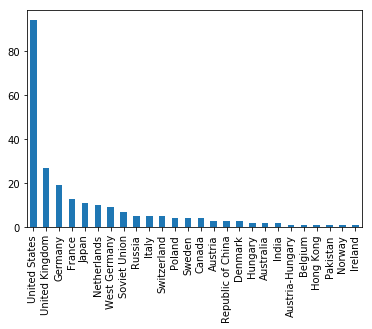

In [9]:
countries.value_counts().plot.bar()

## Add Wikipedia entries to nobel_df

We now want to gather the text from each physicist's associated Wikipedia page. The following code will gather the links for each physicist, and place them in a new dataframe: link_df. We will then merge this with nobel_df. Finally, we use these links to extract the text from the Wikipedia pages. 

Our new dataframe is named nobel_merged_df. It contains the each Nobel Laureate, along with text from the associated Wiki page, link to said Wiki page, year they won, etc.

- ### Gather physicist page links

In [10]:
from httplib2 import Http
from bs4 import BeautifulSoup, SoupStrainer

http = Http()
status, response = http.request(url)

table = BeautifulSoup(response, "lxml", parse_only=SoupStrainer('table'))
link_df = pd.DataFrame([[x.string, x["href"]] for x in table.contents[1].find_all("a")],
                       columns=["Text", "link"]).drop_duplicates()

link_df

,Text,link
0,[A],#endnote_1
1,[B],#endnote_2
2,[C],#endnote_3
3,None,/wiki/File:WilhelmR%C3%B6ntgen.JPG
4,Wilhelm Conrad Röntgen,/wiki/Wilhelm_R%C3%B6ntgen
5,Germany,/wiki/German_Empire
6,rays,/wiki/R%C3%B6ntgen_ray
7,[8],#cite_note-8
8,None,/wiki/File:H_A_Lorentz_(Nobel).jpg
9,Hendrik Lorentz,/wiki/Hendrik_Lorentz


- ### Merge nobel_df + link_df = nobel_merged_df

In [11]:
nobel_merged_df =  nobel_df.merge(link_df, how = 'inner', left_on = 'Laureate', right_on = 'Text')
nobel_merged_df

,Year,Laureate,Country,Rationale,Country_list,Text,link
0,1901,Wilhelm Conrad Röntgen,Germany,"""in recognition of the extraordinary services ...",[Germany],Wilhelm Conrad Röntgen,/wiki/Wilhelm_R%C3%B6ntgen
1,1902,Hendrik Lorentz,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Hendrik Lorentz,/wiki/Hendrik_Lorentz
2,1902,Pieter Zeeman,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Pieter Zeeman,/wiki/Pieter_Zeeman
3,1903,Antoine Henri Becquerel,France,"""for his discovery of spontaneous radioactivity""",[France],Antoine Henri Becquerel,/wiki/Henri_Becquerel
4,1903,Pierre Curie,France,"""for their joint researches on the radiation p...",[France],Pierre Curie,/wiki/Pierre_Curie
5,1903,Maria Skłodowska-Curie,Poland\n France,"""for their joint researches on the radiation p...","[Poland, France]",Maria Skłodowska-Curie,/wiki/Maria_Sk%C5%82odowska-Curie
6,1904,Lord Rayleigh,United Kingdom,"""for his investigations of the densities of th...",[United Kingdom],Lord Rayleigh,"/wiki/John_William_Strutt,_3rd_Baron_Rayleigh"
7,1905,Philipp Eduard Anton von Lenard,Austria-Hungary\n Germany,"""for his work on cathode rays""","[Austria-Hungary, Germany]",Philipp Eduard Anton von Lenard,/wiki/Philipp_Lenard
8,1906,Joseph John Thomson,United Kingdom,"""for his theoretical and experimental investig...",[United Kingdom],Joseph John Thomson,/wiki/J._J._Thomson
9,1907,Albert Abraham Michelson,United States\n Poland,"""for his optical precision instruments and the...","[United States, Poland]",Albert Abraham Michelson,/wiki/Albert_A._Michelson


- ### Extract text associated with each link

In [12]:
def get_text(link, root_website = "https://en.wikipedia.org"):    
    http = Http()
    status, response = http.request(root_website + link)

    body = BeautifulSoup(response, "lxml", parse_only=SoupStrainer("div", {"id":"mw-content-text"}))
    return BeautifulSoup.get_text(body.contents[1])

nobel_merged_df.set_index("Laureate", inplace=True)

# Extract the text of the wikipedia page associated to each physicist
nobel_merged_df["Bio"] =  nobel_merged_df['link'].apply(get_text)
nobel_merged_df["Bio"]

Laureate
Wilhelm Conrad Röntgen             \n\nWilhelm Röntgen\n\n\n\n\n\nBorn\nWilhelm C...
Hendrik Lorentz                    Not to be confused with Hendrikus Albertus Lor...
Pieter Zeeman                      Pieter Zeeman\nBorn\n(1865-05-25)25 May 1865Zo...
Antoine Henri Becquerel            For other uses, see Becquerel (disambiguation)...
Pierre Curie                       \n\nPierre Curie\n\n\n\nPierre Curie, c. 1906\...
Maria Skłodowska-Curie             This article is about the Polish-French physic...
Lord Rayleigh                      \n\nThe Lord RayleighOM PRS\nBorn\n(1842-11-12...
Philipp Eduard Anton von Lenard    "Waterfall effect" redirects here. For the ill...
Joseph John Thomson                This article is about the Nobel laureate and p...
Albert Abraham Michelson           Not to be confused with the athlete Albert Mic...
Gabriel Lippmann                   \n\nGabriel Lippmann\n\n\n\n\n\nBorn\nJonas Fe...
Guglielmo Marconi                  "Marconi" redirects h

## Cleaning up raw Wikipedia text.

As we can see, the raw text from Wikipedia is not cleaned, and especially not ready to be analyzed. We remove the following:

- Punctuation & numbers
- Whitespace
- Stop words (common words which "do not carry significant information of a specific text")
- One character words
- Words which occur less than 4 times

After that, we will remove all duplicates, keeping each word only once per (applicable) physicist. We believe these steps will leave us only those words which are important to identify the field of physics each physicist practices.


- ### Write/apply function to remove punctuation/numbers

In [13]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [14]:
def clean_string(string):
    for p in punctuation + "1234567890":
        string = string.replace(p,'').lower()
    return string
    #pass

# Apply this function to the "Bio" column
nobel_merged_df["Bio"] =  nobel_merged_df["Bio"].apply(clean_string)
nobel_merged_df["Bio"]

Laureate
Wilhelm Conrad Röntgen             \n\nwilhelm röntgen\n\n\n\n\n\nborn\nwilhelm c...
Hendrik Lorentz                    not to be confused with hendrikus albertus lor...
Pieter Zeeman                      pieter zeeman\nborn\n may zonnemaire netherlan...
Antoine Henri Becquerel            for other uses see becquerel disambiguation\n\...
Pierre Curie                       \n\npierre curie\n\n\n\npierre curie c \n\n\n\...
Maria Skłodowska-Curie             this article is about the polishfrench physici...
Lord Rayleigh                      \n\nthe lord rayleighom prs\nborn\n november l...
Philipp Eduard Anton von Lenard    waterfall effect redirects here for the illuso...
Joseph John Thomson                this article is about the nobel laureate and p...
Albert Abraham Michelson           not to be confused with the athlete albert mic...
Gabriel Lippmann                   \n\ngabriel lippmann\n\n\n\n\n\nborn\njonas fe...
Guglielmo Marconi                  marconi redirects her

Right now, our "Bio" column is a column of strings - one string per physicist, representing their Wikipedia page. We want to split each of these strings into a list of words, so that we can use each individual word for analysis.

- ### Split the "Bio" column as a column of lists of the words 

In [15]:
nobel_merged_df["Bio_list"] =  nobel_merged_df['Bio'].str.split()
nobel_merged_df["Bio_list"]

Laureate
Wilhelm Conrad Röntgen             [wilhelm, röntgen, born, wilhelm, conrad, rönt...
Hendrik Lorentz                    [not, to, be, confused, with, hendrikus, alber...
Pieter Zeeman                      [pieter, zeeman, born, may, zonnemaire, nether...
Antoine Henri Becquerel            [for, other, uses, see, becquerel, disambiguat...
Pierre Curie                       [pierre, curie, pierre, curie, c, born, may, p...
Maria Skłodowska-Curie             [this, article, is, about, the, polishfrench, ...
Lord Rayleigh                      [the, lord, rayleighom, prs, born, november, l...
Philipp Eduard Anton von Lenard    [waterfall, effect, redirects, here, for, the,...
Joseph John Thomson                [this, article, is, about, the, nobel, laureat...
Albert Abraham Michelson           [not, to, be, confused, with, the, athlete, al...
Gabriel Lippmann                   [gabriel, lippmann, born, jonas, ferdinand, ga...
Guglielmo Marconi                  [marconi, redirects, 

Good! Our "Bio_list" column is a column of lists - each list containing each word from the associated physicist's Wikipedia page. We resume cleaning up our data.

- ### Write/apply function to remove `None` elements from a list

In [16]:
def remove(list_to_clean, element_to_remove=[None, ""]):
    list_cleaned = [x for x in list_to_clean if x not in element_to_remove]
    return list_cleaned

# Apply function to the "Bio_list" column
nobel_merged_df["Bio_list"] =  nobel_merged_df['Bio_list'].apply(remove)
nobel_merged_df

,Year,Country,Rationale,Country_list,Text,link,Bio,Bio_list
Laureate,,,,,,,,
Wilhelm Conrad Röntgen,1901,Germany,"""in recognition of the extraordinary services ...",[Germany],Wilhelm Conrad Röntgen,/wiki/Wilhelm_R%C3%B6ntgen,\n\nwilhelm röntgen\n\n\n\n\n\nborn\nwilhelm c...,"[wilhelm, röntgen, born, wilhelm, conrad, rönt..."
Hendrik Lorentz,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Hendrik Lorentz,/wiki/Hendrik_Lorentz,not to be confused with hendrikus albertus lor...,"[not, to, be, confused, with, hendrikus, alber..."
Pieter Zeeman,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Pieter Zeeman,/wiki/Pieter_Zeeman,pieter zeeman\nborn\n may zonnemaire netherlan...,"[pieter, zeeman, born, may, zonnemaire, nether..."
Antoine Henri Becquerel,1903,France,"""for his discovery of spontaneous radioactivity""",[France],Antoine Henri Becquerel,/wiki/Henri_Becquerel,for other uses see becquerel disambiguation\n\...,"[for, other, uses, see, becquerel, disambiguat..."
Pierre Curie,1903,France,"""for their joint researches on the radiation p...",[France],Pierre Curie,/wiki/Pierre_Curie,\n\npierre curie\n\n\n\npierre curie c \n\n\n\...,"[pierre, curie, pierre, curie, c, born, may, p..."
Maria Skłodowska-Curie,1903,Poland\n France,"""for their joint researches on the radiation p...","[Poland, France]",Maria Skłodowska-Curie,/wiki/Maria_Sk%C5%82odowska-Curie,this article is about the polishfrench physici...,"[this, article, is, about, the, polishfrench, ..."
Lord Rayleigh,1904,United Kingdom,"""for his investigations of the densities of th...",[United Kingdom],Lord Rayleigh,"/wiki/John_William_Strutt,_3rd_Baron_Rayleigh",\n\nthe lord rayleighom prs\nborn\n november l...,"[the, lord, rayleighom, prs, born, november, l..."
Philipp Eduard Anton von Lenard,1905,Austria-Hungary\n Germany,"""for his work on cathode rays""","[Austria-Hungary, Germany]",Philipp Eduard Anton von Lenard,/wiki/Philipp_Lenard,waterfall effect redirects here for the illuso...,"[waterfall, effect, redirects, here, for, the,..."
Joseph John Thomson,1906,United Kingdom,"""for his theoretical and experimental investig...",[United Kingdom],Joseph John Thomson,/wiki/J._J._Thomson,this article is about the nobel laureate and p...,"[this, article, is, about, the, nobel, laureat..."


- ### Remove stopdwords

In [17]:
# Download stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\black\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [18]:
words_to_remove = set(stopwords.words('english'))

# Remove the stop words
nobel_merged_df["Bio_list"] =  nobel_merged_df["Bio_list"].apply(remove, element_to_remove = words_to_remove)
nobel_merged_df["Bio_list"]

Laureate
Wilhelm Conrad Röntgen             [wilhelm, röntgen, born, wilhelm, conrad, rönt...
Hendrik Lorentz                    [confused, hendrikus, albertus, lorentz, ludvi...
Pieter Zeeman                      [pieter, zeeman, born, may, zonnemaire, nether...
Antoine Henri Becquerel            [uses, see, becquerel, disambiguation, antoine...
Pierre Curie                       [pierre, curie, pierre, curie, c, born, may, p...
Maria Skłodowska-Curie             [article, polishfrench, physicist, uses, see, ...
Lord Rayleigh                      [lord, rayleighom, prs, born, november, langfo...
Philipp Eduard Anton von Lenard    [waterfall, effect, redirects, illusory, visua...
Joseph John Thomson                [article, nobel, laureate, physicist, moral, p...
Albert Abraham Michelson           [confused, athlete, albert, michelsen, albert,...
Gabriel Lippmann                   [gabriel, lippmann, born, jonas, ferdinand, ga...
Guglielmo Marconi                  [marconi, redirects, 

- ### Write/apply function to removes one-character words

In [19]:
def remove_one(list_to_clean):
    list_cleaned = [x for x in list_to_clean if len(x) > 1]
    return list_cleaned

In [20]:
# Apply function to the "bio_list" column
nobel_merged_df["Bio_list"] = nobel_merged_df["Bio_list"].apply(remove_one)
nobel_merged_df["Bio_list"]

Laureate
Wilhelm Conrad Röntgen             [wilhelm, röntgen, born, wilhelm, conrad, rönt...
Hendrik Lorentz                    [confused, hendrikus, albertus, lorentz, ludvi...
Pieter Zeeman                      [pieter, zeeman, born, may, zonnemaire, nether...
Antoine Henri Becquerel            [uses, see, becquerel, disambiguation, antoine...
Pierre Curie                       [pierre, curie, pierre, curie, born, may, pari...
Maria Skłodowska-Curie             [article, polishfrench, physicist, uses, see, ...
Lord Rayleigh                      [lord, rayleighom, prs, born, november, langfo...
Philipp Eduard Anton von Lenard    [waterfall, effect, redirects, illusory, visua...
Joseph John Thomson                [article, nobel, laureate, physicist, moral, p...
Albert Abraham Michelson           [confused, athlete, albert, michelsen, albert,...
Gabriel Lippmann                   [gabriel, lippmann, born, jonas, ferdinand, ga...
Guglielmo Marconi                  [marconi, redirects, 

- ### Write/apply function to remove all words occuring < 4 times

In [21]:
def remove_n_occurrance(list_to_clean, n = 1):
    list_cleaned = [x for x in list_to_clean if list_to_clean.count(x) > n]
    return list_cleaned

In [22]:
# Apply this function to the "bio_list" column
nobel_merged_df["Bio_list"] =  nobel_merged_df["Bio_list"].apply(remove_n_occurrance, n = 4)
nobel_merged_df["Bio_list"]

Laureate
Wilhelm Conrad Röntgen             [wilhelm, röntgen, wilhelm, conrad, röntgen, g...
Hendrik Lorentz                    [lorentz, see, also, lorentz, hendrik, antoon,...
Pieter Zeeman                      [pieter, zeeman, amsterdam, university, zeeman...
Antoine Henri Becquerel            [becquerel, antoine, henri, becquerel, henri, ...
Pierre Curie                       [pierre, curie, pierre, curie, paris, died, ap...
Maria Skłodowska-Curie             [physicist, see, marie, curie, name, family, n...
Lord Rayleigh                      [lord, essex, june, essex, prize, royal, medal...
Philipp Eduard Anton von Lenard    [effect, effect, philipp, lenard, philipp, len...
Joseph John Thomson                [nobel, thomson, sir, thomson, born, joseph, j...
Albert Abraham Michelson           [albert, albert, michelson, may, california, u...
Gabriel Lippmann                   [gabriel, lippmann, gabriel, lippmann, luxembo...
Guglielmo Marconi                  [marconi, see, marcon

- ### Write/apply function to keep each element per list only once

In [23]:
def remove_duplicates(list_to_clean):
    cleaned_list = set(list_to_clean)
    return cleaned_list

In [24]:
# Apply this function to the "bio_list" column
nobel_merged_df["Bio_list"] = nobel_merged_df["Bio_list"].apply(remove_duplicates)
# nobel_merged_df["Bio_list"]

Now that our Nobel prize biographies are cleaned up for analysis, we move on to examining the Wikipedia entries for the six major physics fields: Nuclear physics; Particle physics; Atomic, molecular, and optical physics; Condensed matter physics; Astrophysics; and Physical cosmology.

Our ultimate goal is to compare the words associated with each physics field to the words associated with each Nobel Prize winner.

## Gather words from physics field Wikipedia pages

We first create the skeleton dataframe we are going to dump all our data in. We then gather and clean data from each physics field's Wikipedia page, using the functions we created to clean the data for the Physicists.

In [25]:
physics_df = pd.DataFrame({"Field": ["Nuclear physics",
                                     "Particle physics", 
                                     "Atomic, molecular, and optical physics", 
                                     "Condensed matter physics", 
                                     "Astrophysics",
                                     "Physical_cosmology"],
                           "link": ["/wiki/Nuclear_physics",
                                     "/wiki/Particle_physics", 
                                     "/wiki/Atomic,_molecular,_and_optical_physics", 
                                     "/wiki/Condensed_matter_physics", 
                                     "/wiki/Astrophysics",
                                     "/wiki/Physical_cosmology"]})

physics_df.set_index("Field", inplace=True)

- ### Gather/clean data

In [26]:
# Apply get_text|clean_string|str.split|remove|remove, element_to remove = words_to_remove|remove_one|remove_n_occurance
# remove_duplicate
physics_df["Text_data"] = physics_df['link'].apply(get_text).apply(clean_string).str.split().apply(remove).apply(remove, element_to_remove = words_to_remove).apply(remove_one).apply(remove_n_occurrance, n = 4).apply(remove_duplicates)

physics_df["Text_data"]

Field
Nuclear physics                           {force, meson, nucleons, neutrons, processes, ...
Particle physics                          {interactions, meson, higgs, press, part, boso...
Atomic, molecular, and optical physics    {treatment, research, lasers, molecular, field...
Condensed matter physics                  {liquids, properties, press, bloch, michael, m...
Astrophysics                              {research, evolution, astronomical, spectrum, ...
Physical_cosmology                        {formation, largest, evolution, began, produce...
Name: Text_data, dtype: object

Awesome! We have Wikipedia data for the physicists (in nobel_merged_df) and for the physics fields (in physics_df). We now want to compare the words between each physicist and physics field. We do the following:
- Write a function to counts the number of words that intersect between two general lists.
- Apply this function between each "Bio_list" of words for each physicist with the list of words for each Physics subfield.
- Store these numbers in new columns in nobel_merged_df (Count_intersect_Nuclear, Count_intersect_Particle, etc.). Thus, each physicist (row) in nobel_merged_df will gain six new columns counting the size of their word INTERSECTION with each subfield.
- Count the total number of words in the UNION between each physicists and physics subfield.
- Divide INTERSECTION by UNION to find proportion of words which each physicist shares with each physics subfield
- Store these proportions in new nobel_merged_df columns: Proba_Nuclear, Proba_Particle, etc.

We will then examine the values for each proportion to classify each physicist.
- ### Write function counting size of intersection b/w 2 lists.

In [27]:
def intersect_count(list1, list2):
    x = set(list1).intersection(list2)
    y = len(x)
    return y

- ### Create "INTERSECT count" columns

In [28]:
nobel_merged_df["Count_intersect_Nuclear"] = nobel_merged_df["Bio_list"].apply(intersect_count,
                                            list2=physics_df["Text_data"]["Nuclear physics"])

nobel_merged_df["Count_intersect_Particle"] = nobel_merged_df["Bio_list"].apply(intersect_count,
                                            list2=physics_df["Text_data"]["Particle physics"])

nobel_merged_df["Count_intersect_Atomic"] = nobel_merged_df["Bio_list"].apply(intersect_count,
                                            list2=physics_df["Text_data"]["Atomic, molecular, and optical physics"])

nobel_merged_df["Count_intersect_Condensed"] = nobel_merged_df["Bio_list"].apply(intersect_count,
                                            list2=physics_df["Text_data"]["Condensed matter physics"])

nobel_merged_df["Count_intersect_Astrophysics"] = nobel_merged_df["Bio_list"].apply(intersect_count,
                                            list2=physics_df["Text_data"]["Astrophysics"])

nobel_merged_df["Count_intersect_Cosmology"] = nobel_merged_df["Bio_list"].apply(intersect_count,
                                            list2=physics_df["Text_data"]["Physical_cosmology"])

nobel_merged_df

,Year,Country,Rationale,Country_list,Text,link,Bio,Bio_list,Count_intersect_Nuclear,Count_intersect_Particle,Count_intersect_Atomic,Count_intersect_Condensed,Count_intersect_Astrophysics,Count_intersect_Cosmology
Laureate,,,,,,,,,,,,,,
Wilhelm Conrad Röntgen,1901,Germany,"""in recognition of the extraordinary services ...",[Germany],Wilhelm Conrad Röntgen,/wiki/Wilhelm_R%C3%B6ntgen,\n\nwilhelm röntgen\n\n\n\n\n\nborn\nwilhelm c...,"{curie, zurich, rays, roentgen, cardboard, who...",3,3,5,9,5,10
Hendrik Lorentz,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Hendrik Lorentz,/wiki/Hendrik_Lorentz,not to be confused with hendrikus albertus lor...,"{archive, biography, funeral, english, general...",16,18,14,22,15,35
Pieter Zeeman,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Pieter Zeeman,/wiki/Pieter_Zeeman,pieter zeeman\nborn\n may zonnemaire netherlan...,"{de, field, lorentz, nobel, leiden, der, scien...",6,3,5,7,3,7
Antoine Henri Becquerel,1903,France,"""for his discovery of spontaneous radioactivity""",[France],Antoine Henri Becquerel,/wiki/Henri_Becquerel,for other uses see becquerel disambiguation\n\...,"{named, curie, de, la, becquerels, biography, ...",5,3,5,7,4,12
Pierre Curie,1903,France,"""for their joint researches on the radiation p...",[France],Pierre Curie,/wiki/Pierre_Curie,\n\npierre curie\n\n\n\npierre curie c \n\n\n\...,"{curie, known, de, pierre, whose, john, dissym...",8,10,9,13,11,15
Maria Skłodowska-Curie,1903,Poland\n France,"""for their joint researches on the radiation p...","[Poland, France]",Maria Skłodowska-Curie,/wiki/Maria_Sk%C5%82odowska-Curie,this article is about the polishfrench physici...,"{panthéon, named, pierre, biography, began, pr...",23,21,15,35,21,42
Lord Rayleigh,1904,United Kingdom,"""for his investigations of the densities of th...",[United Kingdom],Lord Rayleigh,"/wiki/John_William_Strutt,_3rd_Baron_Rayleigh",\n\nthe lord rayleighom prs\nborn\n november l...,"{named, research, de, vol, papers, whose, robe...",6,9,9,15,10,14
Philipp Eduard Anton von Lenard,1905,Austria-Hungary\n Germany,"""for his work on cathode rays""","[Austria-Hungary, Germany]",Philipp Eduard Anton von Lenard,/wiki/Philipp_Lenard,waterfall effect redirects here for the illuso...,"{philipp, studies, rays, photoelectric, nobel,...",2,7,5,8,7,10
Joseph John Thomson,1906,United Kingdom,"""for his theoretical and experimental investig...",[United Kingdom],Joseph John Thomson,/wiki/J._J._Thomson,this article is about the nobel laureate and p...,"{joseph, paget, press, james, taylor, laborato...",24,20,19,27,12,33


- ### Write/apply function to count the total number of unique words contained in UNION

In [29]:
def total_count(list1, list2):
    x = len(list1 | list2)
    return x

# Create those columns
nobel_merged_df["Count_total_Nuclear"] = nobel_merged_df["Bio_list"].apply(total_count,
                                        list2 = (physics_df["Text_data"]["Nuclear physics"]) )
nobel_merged_df["Count_total_Particle"] = nobel_merged_df["Bio_list"].apply(total_count,
                                        list2 = (physics_df["Text_data"]["Particle physics"]) )
nobel_merged_df["Count_total_Atomic"] = nobel_merged_df["Bio_list"].apply(total_count,
                                        list2 = (physics_df["Text_data"]["Atomic, molecular, and optical physics"]) )
nobel_merged_df["Count_total_Condensed"] = nobel_merged_df["Bio_list"].apply(total_count,
                                        list2 = (physics_df["Text_data"]["Condensed matter physics"]) )
nobel_merged_df["Count_total_Astrophysics"] = nobel_merged_df["Bio_list"].apply(total_count,
                                        list2 = (physics_df["Text_data"]["Astrophysics"]) )
nobel_merged_df["Count_total_Cosmology"] = nobel_merged_df["Bio_list"].apply(total_count,
                                        list2 = (physics_df["Text_data"]["Physical_cosmology"]) )

nobel_merged_df

,Year,Country,Rationale,Country_list,Text,link,Bio,Bio_list,Count_intersect_Nuclear,Count_intersect_Particle,Count_intersect_Atomic,Count_intersect_Condensed,Count_intersect_Astrophysics,Count_intersect_Cosmology,Count_total_Nuclear,Count_total_Particle,Count_total_Atomic,Count_total_Condensed,Count_total_Astrophysics,Count_total_Cosmology
Laureate,,,,,,,,,,,,,,,,,,,,
Wilhelm Conrad Röntgen,1901,Germany,"""in recognition of the extraordinary services ...",[Germany],Wilhelm Conrad Röntgen,/wiki/Wilhelm_R%C3%B6ntgen,\n\nwilhelm röntgen\n\n\n\n\n\nborn\nwilhelm c...,"{curie, zurich, rays, roentgen, cardboard, who...",3,3,5,9,5,10,134,133,102,196,103,221
Hendrik Lorentz,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Hendrik Lorentz,/wiki/Hendrik_Lorentz,not to be confused with hendrikus albertus lor...,"{archive, biography, funeral, english, general...",16,18,14,22,15,35,182,179,154,244,154,257
Pieter Zeeman,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Pieter Zeeman,/wiki/Pieter_Zeeman,pieter zeeman\nborn\n may zonnemaire netherlan...,"{de, field, lorentz, nobel, leiden, der, scien...",6,3,5,7,3,7,120,122,91,187,94,213
Antoine Henri Becquerel,1903,France,"""for his discovery of spontaneous radioactivity""",[France],Antoine Henri Becquerel,/wiki/Henri_Becquerel,for other uses see becquerel disambiguation\n\...,"{named, curie, de, la, becquerels, biography, ...",5,3,5,7,4,12,147,148,117,213,119,234
Pierre Curie,1903,France,"""for their joint researches on the radiation p...",[France],Pierre Curie,/wiki/Pierre_Curie,\n\npierre curie\n\n\n\npierre curie c \n\n\n\...,"{curie, known, de, pierre, whose, john, dissym...",8,10,9,13,11,15,135,132,104,198,103,222
Maria Skłodowska-Curie,1903,Poland\n France,"""for their joint researches on the radiation p...","[Poland, France]",Maria Skłodowska-Curie,/wiki/Maria_Sk%C5%82odowska-Curie,this article is about the polishfrench physici...,"{panthéon, named, pierre, biography, began, pr...",23,21,15,35,21,42,276,277,254,332,249,351
Lord Rayleigh,1904,United Kingdom,"""for his investigations of the densities of th...",[United Kingdom],Lord Rayleigh,"/wiki/John_William_Strutt,_3rd_Baron_Rayleigh",\n\nthe lord rayleighom prs\nborn\n november l...,"{named, research, de, vol, papers, whose, robe...",6,9,9,15,10,14,142,138,109,201,109,228
Philipp Eduard Anton von Lenard,1905,Austria-Hungary\n Germany,"""for his work on cathode rays""","[Austria-Hungary, Germany]",Philipp Eduard Anton von Lenard,/wiki/Philipp_Lenard,waterfall effect redirects here for the illuso...,"{philipp, studies, rays, photoelectric, nobel,...",2,7,5,8,7,10,131,125,98,193,97,217
Joseph John Thomson,1906,United Kingdom,"""for his theoretical and experimental investig...",[United Kingdom],Joseph John Thomson,/wiki/J._J._Thomson,this article is about the nobel laureate and p...,"{joseph, paget, press, james, taylor, laborato...",24,20,19,27,12,33,206,209,181,271,189,291


- ### Compute proportion (Intersect/Union)

In [30]:
nobel_merged_df["Proba_Nuclear"] = nobel_merged_df["Count_intersect_Nuclear"] / nobel_merged_df["Count_total_Nuclear"]
nobel_merged_df["Proba_Particle"] = nobel_merged_df["Count_intersect_Particle"] / nobel_merged_df["Count_total_Particle"]
nobel_merged_df["Proba_Atomic"] = nobel_merged_df["Count_intersect_Atomic"] / nobel_merged_df["Count_total_Atomic"]
nobel_merged_df["Proba_Condensed"] = nobel_merged_df["Count_intersect_Condensed"] / nobel_merged_df["Count_total_Condensed"]
nobel_merged_df["Proba_Astrophysics"] = nobel_merged_df["Count_intersect_Astrophysics"] / nobel_merged_df["Count_total_Astrophysics"]
nobel_merged_df["Proba_Cosmology"] = nobel_merged_df["Count_intersect_Cosmology"] / nobel_merged_df["Count_total_Cosmology"]

nobel_merged_df

,Year,Country,Rationale,Country_list,Text,link,Bio,Bio_list,Count_intersect_Nuclear,Count_intersect_Particle,...,Count_total_Atomic,Count_total_Condensed,Count_total_Astrophysics,Count_total_Cosmology,Proba_Nuclear,Proba_Particle,Proba_Atomic,Proba_Condensed,Proba_Astrophysics,Proba_Cosmology
Laureate,,,,,,,,,,,,,,,,,,,,,
Wilhelm Conrad Röntgen,1901,Germany,"""in recognition of the extraordinary services ...",[Germany],Wilhelm Conrad Röntgen,/wiki/Wilhelm_R%C3%B6ntgen,\n\nwilhelm röntgen\n\n\n\n\n\nborn\nwilhelm c...,"{curie, zurich, rays, roentgen, cardboard, who...",3,3,...,102,196,103,221,0.022388,0.022556,0.049020,0.045918,0.048544,0.045249
Hendrik Lorentz,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Hendrik Lorentz,/wiki/Hendrik_Lorentz,not to be confused with hendrikus albertus lor...,"{archive, biography, funeral, english, general...",16,18,...,154,244,154,257,0.087912,0.100559,0.090909,0.090164,0.097403,0.136187
Pieter Zeeman,1902,Netherlands,"""in recognition of the extraordinary service t...",[Netherlands],Pieter Zeeman,/wiki/Pieter_Zeeman,pieter zeeman\nborn\n may zonnemaire netherlan...,"{de, field, lorentz, nobel, leiden, der, scien...",6,3,...,91,187,94,213,0.050000,0.024590,0.054945,0.037433,0.031915,0.032864
Antoine Henri Becquerel,1903,France,"""for his discovery of spontaneous radioactivity""",[France],Antoine Henri Becquerel,/wiki/Henri_Becquerel,for other uses see becquerel disambiguation\n\...,"{named, curie, de, la, becquerels, biography, ...",5,3,...,117,213,119,234,0.034014,0.020270,0.042735,0.032864,0.033613,0.051282
Pierre Curie,1903,France,"""for their joint researches on the radiation p...",[France],Pierre Curie,/wiki/Pierre_Curie,\n\npierre curie\n\n\n\npierre curie c \n\n\n\...,"{curie, known, de, pierre, whose, john, dissym...",8,10,...,104,198,103,222,0.059259,0.075758,0.086538,0.065657,0.106796,0.067568
Maria Skłodowska-Curie,1903,Poland\n France,"""for their joint researches on the radiation p...","[Poland, France]",Maria Skłodowska-Curie,/wiki/Maria_Sk%C5%82odowska-Curie,this article is about the polishfrench physici...,"{panthéon, named, pierre, biography, began, pr...",23,21,...,254,332,249,351,0.083333,0.075812,0.059055,0.105422,0.084337,0.119658
Lord Rayleigh,1904,United Kingdom,"""for his investigations of the densities of th...",[United Kingdom],Lord Rayleigh,"/wiki/John_William_Strutt,_3rd_Baron_Rayleigh",\n\nthe lord rayleighom prs\nborn\n november l...,"{named, research, de, vol, papers, whose, robe...",6,9,...,109,201,109,228,0.042254,0.065217,0.082569,0.074627,0.091743,0.061404
Philipp Eduard Anton von Lenard,1905,Austria-Hungary\n Germany,"""for his work on cathode rays""","[Austria-Hungary, Germany]",Philipp Eduard Anton von Lenard,/wiki/Philipp_Lenard,waterfall effect redirects here for the illuso...,"{philipp, studies, rays, photoelectric, nobel,...",2,7,...,98,193,97,217,0.015267,0.056000,0.051020,0.041451,0.072165,0.046083
Joseph John Thomson,1906,United Kingdom,"""for his theoretical and experimental investig...",[United Kingdom],Joseph John Thomson,/wiki/J._J._Thomson,this article is about the nobel laureate and p...,"{joseph, paget, press, james, taylor, laborato...",24,20,...,181,271,189,291,0.116505,0.095694,0.104972,0.099631,0.063492,0.113402


We have almost all the data we need in nobel_merged_df. All that is left is to categorize each physicist by subfield, by choosing the subfield with which they share the highest proportion of words. Before we do that, however, we will normalize the probabilities.

## Classifying physicists.

In [31]:
proba_cols = ["Proba_Nuclear",
              "Proba_Particle",
              "Proba_Atomic",
              "Proba_Condensed",
              "Proba_Astrophysics",
              "Proba_Cosmology"]

# We normalize the probability to 1
nobel_merged_df[proba_cols] = nobel_merged_df[proba_cols].apply(lambda x: x / sum(x), 1)

In [32]:
# Which field each physicist belongs to?
nobel_merged_df['field'] = nobel_merged_df[proba_cols].idxmax(axis =1)

In [33]:
nobel_merged_df['field']

Laureate
Wilhelm Conrad Röntgen                   Proba_Atomic
Hendrik Lorentz                       Proba_Cosmology
Pieter Zeeman                            Proba_Atomic
Antoine Henri Becquerel               Proba_Cosmology
Pierre Curie                       Proba_Astrophysics
Maria Skłodowska-Curie                Proba_Cosmology
Lord Rayleigh                      Proba_Astrophysics
Philipp Eduard Anton von Lenard    Proba_Astrophysics
Joseph John Thomson                     Proba_Nuclear
Albert Abraham Michelson              Proba_Cosmology
Gabriel Lippmann                      Proba_Cosmology
Guglielmo Marconi                     Proba_Cosmology
Karl Ferdinand Braun               Proba_Astrophysics
Johannes Diderik van der Waals        Proba_Condensed
Wilhelm Wien                             Proba_Atomic
Nils Gustaf Dalén                        Proba_Atomic
Heike Kamerlingh-Onnes                Proba_Condensed
Max von Laue                       Proba_Astrophysics
William Henry Bragg

In [ ]:
# Use to set the max amount of rows displayed
from IPython.display import display

pd.options.display.max_rows=20